## Bayesian Optimization with Scikit-Optimize

In this notebook, we will use **Bayesian Optimization** to select the best **hyperparameters** for a Gradient Boosting Classifier, from the xgb package. We optimize over the same hyperparameter space as in the notebook of Hyperopt in **section 5**, for comparison.

### Hyperparameter Tunning Procedure

To tune the hyper-parameters of our model we need to:

- define a model
- decide which parameters to optimize
- define the objective function we want to minimize.


### NOTE

Scikit-Optimize will always **minimize** the objective function, so if we want to maximize a function, for example the roc-auc, we need to **negate** the metric. Thus, instead of maximizing the roc-auc, we minimize the -roc-auc.

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score

import xgboost as xgb

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

In [2]:
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0: 1, 1: 0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
y.value_counts()/len(y)

0    0.627417
1    0.372583
Name: count, dtype: float64

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((455, 30), (114, 30))

## Define the hyperparameter space

Sckit-Optiization provides an utility function to create the range of vaues to examine for each hyperparemeters.

In [5]:
param_grid = [
    Integer(200, 500, name='n_estimators'),
    Integer(1,10, name='max_depth'),
    Real(0.01, 1, name='learning_rate'),
    Categorical(['gbtree','dart'], name = 'booster'),
    Real(0.01, 10, name = 'gamma'),
    Real(0.50, 0.90, name = 'subsample'),
    Real(0.50, 0.90, name = 'colsample_bytree'),
    Real(0.50, 0.90, name = 'colsample_bylevel'),
    Real(0.50, 0.90, name = 'colsample_bynode'),
    Real(0.01, 10, name = 'reg_lambda'),
]

type(param_grid)

list

## Define the model


In [6]:
gbm = xgb.XGBClassifier(random_state = 42)

In [9]:
## Define the objective function
# This is the function that hyperopt will minimize

@use_named_args(param_grid)
def objective(**params):
    gbm.set_params(**params)

    value = np.mean(
        gbm,
        X_train,
        y_train,
        cv = 3,
        n_jobs = -4,
        scoring = 'accuracy',
    )

    return -value

## Bayesian Optimization

In [14]:
from sklearn.model_selection import cross_val_score

value = cross_val_score(
    gbm, X_train, y_train,
    cv=3,
    n_jobs=-4,
    scoring='accuracy'
).mean()


In [16]:
"Best score = %.4f" % value

'Best score = 0.9274'

In [18]:
# Execute a otimização bayesiana
result = gp_minimize(objective, param_grid, n_calls=50, random_state=42)

# Acessar os melhores parâmetros
best_params = result.x
print(best_params)

TypeError: mean() got an unexpected keyword argument 'cv'

## Evaluate convergence of the search


ValueError: Cannot plot convergence trace for float64 object 0.9274427791332637

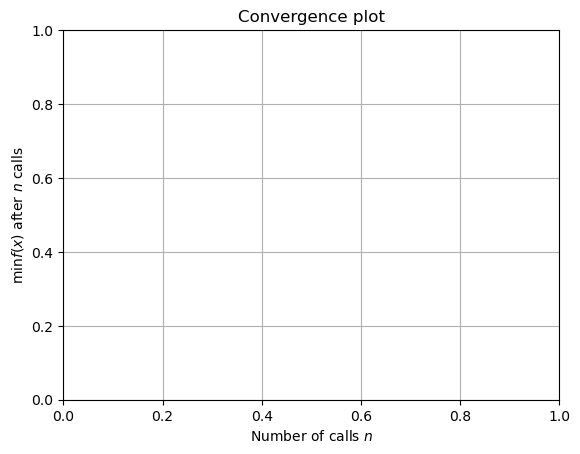

In [20]:
plot_convergence(value)